# Bildklassifikation mit dem MURA-Datensatz

Bei der Klassifikation geht es darum, einem Bild ein Label aus einer vorgegebenen Menge an möglichen Labels zuzuweisen. Im Vergleich zur Segmentierung und Objektdetektion ist diese Aufgabe die Einfachste.

In diesem Jupyter-Notebook soll ein Model mit PyTorch von Grund auf neu trainiert (from scratch) werden, welches Bilder des MURA-Datensatzes in eine von sieben Extremitätsklassen einordnen kann.

## Datensatz

Der [MURA](https://stanfordmlgroup.github.io/competitions/mura/) (**mu**sculoskeletal **ra**diographs) Datensatz besteht aus 40.561 Röntgenbildern von Oberkörperextremitäten der Kategorien: Ellbogen, Finger, Unterarm, Hand, Oberarm, Schulter, und Handgelenk. Zusätzlich ist jedem Bild das Label normal oder abnormal zugeordnet.

<img src="https://stanfordmlgroup.github.io/competitions/mura/img/dataset.png" width="500"/>
Quelle: stanfordmlgroup.github.io


## Jupyter-Notebook

Jupyter-Notebooks sind interaktive Python-Scripte, in denen Markdown und sogar Latex zur Dokumentation verwendet werden kann. In diesem Abschnitt sollen einerseits allgemeine Informationen wie Tastenkombinationen und übliche Workflows, andererseits aber auch für diesen Workshop und die verwendete Hardware spezifische Informationen im Umgang mit Python und Jupyter-Notebooks geliefert werden.

### Wichtiges auf einen Blick (a.k.a. TL;DR)

- **beim Wechseln auf ein anderes Notebook immer den Kernel beenden (Kernel -> Shutdown)**
- **Shift + Enter** zum Ausführen der aktiven Zelle
- **Strg + Shift + p** zum Öffnen der Kommandopalette (**Strg + Shift + f** im Firefox)
- **Shift + o** zum Togglen des Zell-Scrollings
- bei Fehlermeldungen im Zweifel **Kernel neustarten (Kernel -> Restart)**
- "Hilfe, ich sehe den Markdown-Code" -> **Shift + Enter** in der entsprechenden Zelle
- "Hilfe, ich bekommen ResourceExhaustion / OutOfMemory (OOM) Fehler" -> **Kernel neustarten, Kernel von anderen noch laufenden Notebooks herunterfahren** (oben links auf das Jupyter-Logo klicken, dann auf den Tab "Running")
- "Hilfe, mein Notebook ist kaputt" -> siehe **Notebook "Wiederherstellung"**
- "Passiert da noch was?" -> ist der **Kreis oben rechts neben "Python 3", ausgefüllt und dunkel** dann ist der Kernel noch am Arbeiten, ist er nicht gefüllt dann ist der Kernel untätig. Die aktuell laufende Zelle ist die von oben gesehen erste bei der auf der linken Seite "In[*]" anstelle von z.B. "In[5]" steht. Es kann aber passieren dass sich der Kernel aufhängt, in dem Fall einfach oben auf __Kernel -> Interrupt__ und die Zelle erneut ausführen


### Überblick & Workflow

Die einzigen beiden Shortcuts die man sich eigentlich nur merken muss sind

- **Shift + Enter** zum Ausführen einer Zelle, und
- **Strg + Shift + p** zum Öffnen der Kommandopalette, von der aus man dann direkt Zugriff auf alle möglichen Befehle hat, inklusive entsprechender Shortcuts

Ein weiterer nützlicher Shortcut ist **Shift + o**, welcher das **Scrolling für Zellenoutput** umschaltet.

Zum **Editieren einer Zelle** genügt ein Doppelklick in die Zelle, bei Code-Zellen reicht es zum Beenden des Editiermodus einfach außerhalb der Zelle zu klicken, bei Dokumentationszellen (wie dieser hier) ist eine Ausführung der Zelle nötig um die Code-Ansicht zu verlassen.

Während eine Zelle ausgeführt wird, wechselt der Kernel-Indikator oben rechts neben "Python 3" von einem hellen Kreis mit dunklem Rand zu einem ausgefüllten dunklen Kreis und springt wieder zurück sobald die Ausführung beendet ist. Wenn mehrere Zellen gleichzeitig ausgeführt wurden, kann man an dem Label in der linken Spalte ablesen, ob die Zelle fertig ausgeführt wurde (**In [ZAHL]:**) oder ob sie gerade ausgeführt wird bzw. auf Ausführung wartet (**In [*]:**). Zusätzlich wird nach Ausführung einer Zelle die Zellenausgabe unterhalb der Zelle angezeigt.

Um den Überblick zu behalten kann es manchmal sinnvoll sein, die **Zellenausgabe zu löschen**. Dies kann u.a. auf diesen beiden Wegen erfolgen:

- oben auf Cell -> Current Outputs / All outputs -> Clear
- oben auf Kernel -> Restart & Clear Output

Der Kernel ist für die Ausführung des Python-Codes zuständig und behält den Kontext (also belegte Variablen, definierte Funktionen und belegter Speicher) seit dem letzten Kernel-(Neu)start. Dies kann zu Problemen führen wenn Zellen in anderer Reihenfolge ausgeführt werden oder Zellen übersprungen werden in denen Variablen oder Funktionen definiert werden die im weiteren Verlauf des Scripts benötigt werden, aber auch wenn **ein anderes Jupyter-Notebook gestartet wird**, da dafür ein weiterer Kernel gestartet wird.

Deswegen beim **Wechseln auf ein anderes Notebook** immer den **Kernel herunterfahren oder neustarten** (oben Kernel -> Restart/Shutdown).

# 1. Imports und Setup

Der erste Schritt besteht in der Installation und dem Import der erforderlichen Python Packages. Falls die erfoderlichen Packages noch nicht installiert wurden, kann dies in der Shell z.B. über `pip install <package-name>` erfolgen. Getestet wurde dieses Beispiel mit den nachfolgend aufgeführten Packages: [Numpy 1.21.2](https://numpy.org/), [Pandas 1.4.2](https://pandas.pydata.org/), [Matplotlib 3.5.1](https://matplotlib.org/), [PyTorch 1.11.0](https://pytorch.org/), [Torchvision 0.12.0](https://pytorch.org/vision/stable/index.html), [PyTorch Image Models 0.6.1](https://github.com/rwightman/pytorch-image-models), [torchinfo 1.6.5](https://github.com/TylerYep/torchinfo), [TorchMetrics 0.7.3](https://torchmetrics.readthedocs.io/en/stable/), [pkbar 0.5](https://github.com/yueyericardo/pkbar)

Im Gegensatz zu Tensorflow reserviert PyTorch immer nur so viel GPU-VRAM (Grafikspeicher), wie zur Ausführung des Codes benötigt wird. Verschiedene Faktoren beeinflussen die benötigte Menge an Grafikspeicher beim Training eines neuronalen Netzes, z.B. die Anzahl der Parameter (Gewichte) des neuronalen Netzes, die Minibatch-Größe (die später im Skript ausführlicher besprochen wird), die Anzahl der Unterprozesse (worker) beim Laden von Daten etc. Mit `torch.cuda.set_per_process_memory_fraction(fraction: float)` kann PyTorch jedoch angewiesen werden, nur einen maximalen Anteil des verfügbaren Grafikspeichers für die Codeausführung zu verwenden, um beispielsweise mehrere Trainingsprozesse gleichzeitig auf einer GPU auszuführen.

In [1]:
import os, math, pkbar, tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

from timm.models import create_model
from torchinfo import summary
from torchmetrics import MeanMetric, Accuracy, F1Score, Precision, Recall, ConfusionMatrix

# Limit the amount of available GPU-VRAM for code execution
#torch.cuda.set_per_process_memory_fraction(0.5)
torch.cuda.empty_cache()

# enable cudnn auto-tuner to find the best algorithms for the underlying hardware
torch.backends.cudnn.benchmark = True
torch.manual_seed(42) # set seed for reproducible results

## 1.1 Ordnerstruktur
Für dieses Beispiel sollten die folgenden Verzeichnisse angelegt werden:
- `ROOT_DIR`: Das Hauptverzeichnis in dem sich das Jupyter-Notebooks befindet (`os.getcwd()` ist hier hilfreich)
- `MODEL_DIR`: Verzeichnis in dem trainierte Modelle abgespeichert werden sollen
- `DATA_DIR`: Verzeichnis in dem sich der Datensatz befinden

In [ ]:
ROOT_DIR = os.path.abspath(os.getcwd()) # current path of the notebook
MODEL_DIR = os.path.join(ROOT_DIR, "models/classification_fromscratch")
DATA_DIR = os.path.join("./dataset/MURA-v1.1/")

print("Directories:")
print("Root directory:", ROOT_DIR)
print("Model directory:", MODEL_DIR)
print("Datasets directory:", DATA_DIR)

Hier kann mit einfachen Linux-Kommandozeilenbefehlen die Ordnerstruktur untersucht werden

In [ ]:
!ls -l $DATA_DIR
!ls -l $DATA_DIR/MURA-v1.1
!ls -l $DATA_DIR/MURA-v1.1/train
!ls -l $ROOT_DIR

# 2. Datensatz

Hier wird der Datensatz definiert. Es gibt in PyTorch viele verschiedene Wege Daten einzulesen, in diesem Beispiel wird zunächst ein Datensatzobjekt mit [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) definiert, welches anhand der Ordnerstruktur `/path/to/dataset/split/class/image.png` Bilddaten einliest und vorverarbeitet. Vorverarbeitungsschritte sowie Transformationsmöglichkeiten zur Data Augmentation können in PyTorch in Form einer Vorverarbeitungspipeline `transforms.Compose` miteinander verkettet und dem Datensatz als `transform` Parameter übergeben werden. Details zu den Transformations- und Vorverarbeitungsschritten können unter dem Link [Transforming and augmenting images](https://pytorch.org/vision/stable/transforms.html) nachgelesen und später zur Optimierung genutzt werden.

In unserem Beispiel ist der Name des Datensatz-Ordners `MURA-v1.1` und die möglichen __Splits__ sind `train` und `valid`, die Klassen entsprechen den Ordnernamen innerhalb der Unterverzeichnisse `train/` sowie `valid/`. `ImageFolder` ordnet die entsprechenden Bilder in den Unterverzeichnissen automatisch den Klassen zu und erstellt Klassenlabels 0-N.

ImageFolder liest die Bilddaten und die zugehörigen Labels nacheinander ein und stellt diese über die Funktion `__getitem__(index: int)` einzeln zur Verfügung. Beim Training eines Modells wollen wir in der Regel mehrere Bilder in Form von "Minibatches" verarbeiten, die Bilddaten in jeder Trainingsepoche neu sortieren und Multiprocessing zum parallelen Laden der Bilddaten verwenden. In PyTorch sind diese Funktionen über den `DataLoader` verfügbar, der ein "Minibatch-Iterable" aus dem Datensatzobjekt erzeugt. Eine wichtige Variable hier ist `BATCH_SIZE`, welche bestimmt wie viele Bilder in ein Minibatch geladen werden. Wählt man diesen Wert zu hoch, kann der reservierte Grafikspeicher nicht ausreichen, wählt man ihn zu niedrig so wird das Training sehr langsam. Für unser Beispiel soll dieser Wert auf 32 gesetzt werden. Mit dem `SubsetRandomSampler` weisen wir den `DataLoader` an, nur 50% der Trainingsdaten zum Training zu verwenden, um die Trainingszeiten für Testzwecke zu beschleunigen. Beim finalen Training sollte der `SubsetRandomSampler` entfernt und mit dem gesamten Trainingsdatensatz trainiert werden. 

In [4]:
# Dataset directory
TRAIN_DATA_DIR = DATA_DIR + 'train/'
VALID_DATA_DIR = DATA_DIR + 'valid/'

BATCH_SIZE = 32 
IMAGE_SIZE = 224 
PRE_CROPPED_SIZE = 256 

# Train data pre-processing and data augmentation pipeline
train_transforms = transforms.Compose([
                        # data augmentation
                        transforms.Resize((PRE_CROPPED_SIZE, PRE_CROPPED_SIZE)), # pre-crop image to PRE_CROPPED_SIZE
                        transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)), # randomly crop a region of IMAGE_SIZE from the pre-cropped image
                        transforms.RandomHorizontalFlip(p=0.5), # randomly flip image horizontally
                        transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10), # randomly rotate (degrees), translate, scale, shear image 
                        
                        # pre-processing: normalize image pixel values to [-1,1]
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

# Valid data pre-processing pipeline
valid_transforms = transforms.Compose([
                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

print("Start preparing dataset... please wait, this may take a while")

# ImageFolder will read images found in subfolers of '/train' and creates mini batches using the DataLoader
train_dataset = ImageFolder(root=TRAIN_DATA_DIR, transform=train_transforms)
train_loader = DataLoader(dataset=train_dataset, 
                          shuffle=False, # shuffling is done by sampler 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multiprocessing
                          # Use a subset (50%) of the training images for faster training (should be removed for final training)
                          sampler=SubsetRandomSampler(torch.randint(high=len(train_dataset), size=(int(len(train_dataset)*0.5),))),
                          pin_memory=True)
print(f'Found {len(train_dataset.samples)} training images belonging to {len(train_dataset.classes)} classes: {train_dataset.classes}')

# ImageFolder will read images found in subfolers of '/valid' and creates mini batches using the DataLoader
valid_dataset = ImageFolder(root=VALID_DATA_DIR, transform=valid_transforms)
valid_loader = DataLoader(dataset=valid_dataset, 
                          shuffle=False, 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multiprocessing
                          pin_memory=True)
print(f'Found {len(valid_dataset.samples)} validation images belonging to {len(valid_dataset.classes)} classes: {valid_dataset.classes}')
print("Dataset prepared")

# make sure these numbers are correct, you can count images using something like
# find path/to/dataset/split -name ".png" | wc -l
# or you just run the script above once and look for the
# "Found X images belonging to Y classes." lines
NUM_TRAINING_SAMPLES = 36808
NUM_VALIDATION_SAMPLES = 3197
CLASSES = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
NUM_CLASSES = len(CLASSES)

Start preparing dataset... please wait, this may take a while
Found 36808 training images belonging to 7 classes: ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
Found 3197 validation images belonging to 7 classes: ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
Dataset prepared


## 2.1. Bilder anzeigen lassen

Im Folgedenen wird ein Minibatch aus dem Trainingsdatensatz extrahieren. Um stattdessen Bilder aus dem Validierungsdatensatz anzuzeigen, einfach den `train_loader` zu `valid_loader` ändern.

Dieser Block kann beliebig oft ausgeführt werden, der ausgewählte Minibatch wird jedes Mal zufällig ausgewählt. Die Bilder aus dem Trainingsdatensatz sind augmentiert.

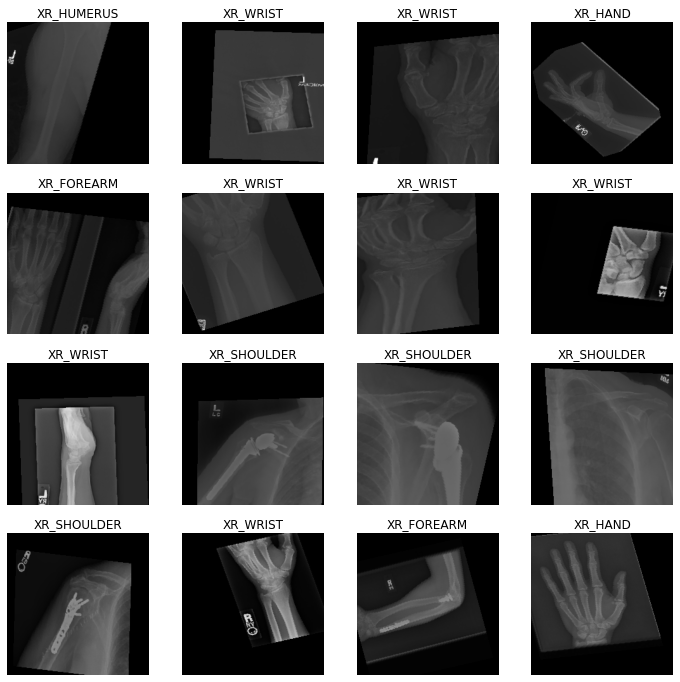

In [5]:
def denormalization(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean 
    return img

def show_batch(images, labels):
    images = images.numpy() 
    labels = labels.numpy()
    
    fig, ax = plt.subplots(4, 4, figsize=(12,12))
    for i, ax in enumerate(ax.flat):
        ax.imshow(denormalization(np.rollaxis(images[i,:,:,:],0,3)), vmin=0, vmax=1, cmap='gray') # np.rollaxis(images[i,:,:,:],0,3)) to swap channel axes to channels last
        ax.set_title(CLASSES[labels[i]])
        ax.axis('off')
    plt.show()

dataiter = iter(train_loader) # get iterator of train_loader 
images, labels = dataiter.next() # get a random batch of train_loader iterator
show_batch(images, labels) # show images of batch 

# 3. Ein Modell von Grund auf neu trainieren (from scratch)

<a id='from_scratch'></a>

## 3.1 Modell-Erstellung
Als nächstes wird das Modell erstellt. In der Variable `MODEL_DIR` ist das Verzeichnis angegeben, in dem Checkpoints  der trainierten Modellgewichte gespeichert werden und beim Fortsetzen des Trainings über die Variable `MODEL_CHECKPOINTS` geladen werden können.

Mit der Funktion `create_model()` können Basismodelle für die Bildklassifizierung aus dem GitHub-Repository [PyTorch Image Models](https://github.com/rwightman/pytorch-image-models) geladen werden. In diesem Fall ein ResNet50, andere Modelle können mit dem Parameter `model_name` angegeben werden. Eine Liste aller Modelle ist im GitHub-Repository verfügbar. In diesem Beispiel wird das Training "from scratch" durchgeführt, d.h. die Gewichte der Schichten des Basismodells sollen zufällig initialisiert werden. Daher muss der Parameter `pretrained` auf `False` gesetzt werden. Die Anzahl der Knoten in der Ausgabeschicht des Basismodell-Klassifikators kann über den Parameter `num_classes` verändert werden und sollte der Anzahl der Klassen im Datensatz entsprechen. 

Mit Hilfe des Packages `torchinfo` und der Funktion `summary()` kann die Struktur des Basismodells übersichtlich dargestellt werden. Alternativ kann dies auch mit der Python-Funktion `print()` erfolgen.   

In [6]:
print("Creating model")
print("model_dir: ", os.path.realpath(MODEL_DIR))
os.makedirs(MODEL_DIR, exist_ok=True)

# Create model
# see https://github.com/rwightman/pytorch-image-models
model = create_model(model_name="resnet50", 
                     pretrained = False,
                     num_classes = NUM_CLASSES)

MODEL_CHECKPOINTS = None # Specifying model checkpoints for continuing training, e.g. f"{MODEL_DIR}/model_epoch1.pth"
if MODEL_CHECKPOINTS: # load model checkpoints if available
    model.load_state_dict(torch.load(MODEL_CHECKPOINTS, map_location="cpu"))

print(summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)))
print(model)

print("Model successfully created")

Creating model
model_dir:  /home/user01/01_classification/models/classification_fromscratch
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 7]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 5

### Verlustfunktion
Maschinelles Lernen ist im Grunde eine Optimierungsaufgabe, die darauf abzielt, einen Fehler zwischen Vorhersagen eines Modells z.B. einem Neuronalen Netz und tatsächlichen Beobachtungen aus einem Datensatz zu minimieren. Um den Fehler zwischen Modellvorhersagen und tatsächlichen Beobachtungen zu quantifizieren, ist eine Verlustfunktion erforderlich. Weichen die Modellvorhersagen zu stark von den tatsächlichen Beobachtungen ab, nimmt die Verlustfunktion einen sehr hohen Wert an, den sogenannten Verlust (eng. loss). Das Ziel des Trainingsprozesses ist es nun, diesen Verlust schrittweise zu minimieren, indem die Gewichte des Neuronalen Netzes mit Hilfe von Optimierungsalgorithmen angepasst werden.

PyTorch hat bereits viele verschiedene [Verlustfunktionen](https://pytorch.org/docs/stable/nn.html#loss-functions) implementiert.
Eine für Klassifikationssaufgaben häufig verwendete Verlustfunktion ist die [Kreuzentropie](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss), die wir in diesem Beispiel ebenfalls verwenden werden. 

In [7]:
# Loss function
loss_function = torch.nn.CrossEntropyLoss() 

### Optimizer
Optimizer sind Optimierungsalgorithmen und für die Anpassung der Gewichte im Trainingsprozess zuständig. PyTorch implementiert bereits eine Reihe von unterschiedlichen [Optimizern](https://pytorch.org/docs/stable/optim.html#module-torch.optim) mit unterschiedlichen Optimierungsverfahren. Wir werden für unser Training den [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) Optimizer nutzen.

Ein wichtiger Parameter der Optimierer ist die Lernrate, mit der das Ausmaß der Gewichtsanpassung pro Trainingsschritt angepasst werden kann. Übliche Lernraten liegen zwischen `0.001` und `0.00001`. Größere Lernraten ermöglichen ein schnelleres Training, können aber auch zu problematischen Sprüngen im Lösungsraum und zu Divergenz (gleichbleibend schlechte Fehler) führen. Kleinere Lernraten sind für das Fine-Tuning geeignet.

__Aufgabe:__ Ersetzen Sie die Variable `LEARN_RATE` durch eine geeignete Lernrate. Experimentieren Sie mit unterschiedlichen Lernraten. 

In [8]:
# optimizer 
LEARN_RATE = 5e-05
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)

### Lernratenanpassung
Mittels Lernratenanpassungen (oft learning rate scheduler genannt) kann die Lernrate während des Trainings dynamisch angepasst werden. Eine übliche Strategie besteht darin, mit hohen Lernraten zu beginnen, um schnell in die Nähe eines lokalen Minimums zu gelangen, und dann mit geringeren Lernraten so nahe wie möglich an dieses lokale Minimum heranzukommen. PyTorch implementiert bereits eine Vielzahl von verschiedenen [Strategien zur Lernratenanpassung](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).  

Für das Training in diesem Beispiel, wollen wir unterschiedliche Strategien zur Lernratenanpassung ausprobieren:
- [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR): Lernratenanpassungen nach festgelegter Epochenanzahl
- [CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR): Lernratenanpassungen entlang eines Kosinuszyklus
- [LambdaLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html#torch.optim.lr_scheduler.LambdaLR): eigenständige Implementierung einer Lernratenanpassungsstrategie für die exponentielle Lernratenanpassungen `LR_EXPDECAY`

\begin{equation*}
lr = lr_{init} \cdot e^{-d \cdot i}
\end{equation*}
mit $lr$ = Lernrate, $lr_{init}$ = initiale Lernrate, $d$ = decay, $i$ = Trainingsepoche 

Einige der in PyTorch implementierten LR-Scheduler benötigen die maximale Anzahl von Trainingsiterationen/Epochen zur Initialisierung. Wir legen dies über die Variable `NUM_EPOCHS` fest. 

__Aufgabe:__ Experimentieren Sie mit unterschiedlichen Strategien zur Lernratenanpassung.

In [9]:
# max. number of training epochs
NUM_EPOCHS = 20 

# lr scheduler strategies (decomment the LR scheduler you want to use)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5, last_epoch=-1, verbose=False) # lr scheduler step strategy
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS, eta_min=1e-05, last_epoch=-1, verbose=False) # learning rate scheduler with cosine annealing strategy
# LR_EXPDECAY = lambda epoch: math.exp(-0.5*epoch) # exponential decay strategy
# lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, LR_EXPDECAY) # learning rate scheduler with exponential decay

### Visualisierung der Lernratenanpassungsstrategie

Um die Auswirkungen der einzelnen Lernratenanpassungsstrategien auf die Lernraten im Verlauf der Trainingsepochen zu visualisiereneinen, kann das nachfolgende Skript verwendet werden. LR-Scheduler, die nicht getestet werden sollen, müssen im Skript auskommentiert werden. 

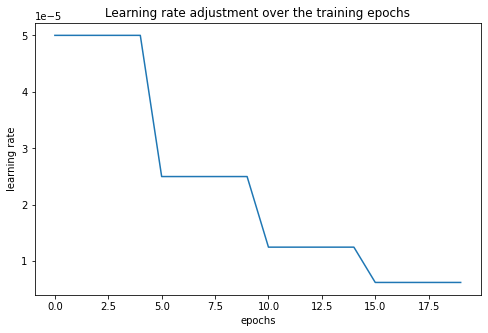

In [10]:
# this optimizer is only used for visualization
optimizer_vis = torch.optim.Adam(model.parameters(), lr=LEARN_RATE) 

# this lr scheduler is only used for visualization (decomment a LR scheduler for visualization purposes)
lr_scheduler_vis = torch.optim.lr_scheduler.StepLR(optimizer_vis, 5, gamma=0.5, last_epoch=-1, verbose=False) # lr scheduler with cosine annealing strategy
#lr_scheduler_vis = torch.optim.lr_scheduler.LambdaLR(optimizer_vis, LR_EXPDECAY) # lr scheduler with previous defined LR_DECAY strategy
#lr_scheduler_vis = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_vis, NUM_EPOCHS, eta_min=1e-05, last_epoch=-1, verbose=False) # lr scheduler with step strategy

learning_rates = []
for i in range(NUM_EPOCHS):
    optimizer_vis.step()
    lr = optimizer_vis.param_groups[0]["lr"] # get current learning rate of optimizer
    learning_rates.append(lr)
    lr_scheduler_vis.step()

# plot graph
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(np.arange(NUM_EPOCHS), learning_rates)
ax.set_xlabel('epochs')
ax.set_ylabel('learning rate')
ax.set_title('Learning rate adjustment over the training epochs')
plt.show()

### Kennzahlen und Logs zur Überwachung des Trainingsfortschritts

Neben dem Verlust können weitere [Kennzahlen](https://de.wikipedia.org/wiki/Beurteilung_eines_bin%C3%A4ren_Klassifikators) bei der Bewertung des Trainingsfortschritts eines Neuronalen Netzwerkes hilfreich sein. Häufig wird zusätzlich der Anteil der korrekt klassifizierten Trainingsbeispiele ermittelt, die sogenannte Klassifikationsgenauigkeit (eng. accuracy). Wichtig! Während der Verlust im Trainingsprozess als Maß für die Optimierung der Netzwerkgewichte zwingend erforderlich ist, dient die Klassifizierungsgenauigkeit lediglich der Überwachung des Trainingsfortschritts und ist daher optional. Das Packages [TorchMetric](https://torchmetrics.readthedocs.io/en/stable/) bietet eine komfortable Lösung zur Erfassung von unterschiedlichen Metriken während des Trainingsprozesses.

Zur späteren Visualisierung des Trainingsprozesses ist es sinnvoll, Verluste und andere Metriken während des Trainings zu protokollieren. In diesem Beispiel werden diese während des Trainings im Dictonary `logs` gespeichert.  

In [11]:
loss_metric = MeanMetric()
accuracy_metric = Accuracy()

logs = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

## 3.2 Modell-Training

Damit PyTorch das Training auf der GPU durchführt, müssen alle wichtigen Komponenten des Trainingsprozesses, wie das Modell selbst, die Verlustfunktion, Metriken, Bilder und Labels aus dem DataLoader usw. in den VRAM der GPU verschoben werden. Dies ist über die Funktion `.to(device)` möglich. `device` ist eine Variable, die den String "cuda" annimmt, wenn eine GPU verfügbar ist, andernfalls den String "cpu" und das Training findet nicht auf einer GPU statt.

In [12]:
device = ("cuda" if torch.cuda.is_available() else "cpu") 

# move model, loss and metrics to GPU-VRAM if available
model = model.to(device)
loss_function = loss_function.to(device)
loss_metric = loss_metric.to(device)
accuracy_metric = accuracy_metric.to(device)

Das eigentliche Training findet nun nachfolgend statt und kann einige Zeit in Anspruch nehmen. Ob der Kernel im Hintergrund noch aktiv ist, lässt sich an dem Kreis oben rechts erkennen - solange der Kreis gefüllt ist, läuft das Skript noch.

Das Training erfolgt Epochenweise `for epoch in range(NUM_EPOCHS):`, wobei eine Trainingsepoche dem Durchlauf aller Minibatches des Trainingsdatensatzes entspricht. Über die Variable `NUM_EPOCHS` (weiter oben definiert) kann die Anzahl der Trainingsepochen angegeben werden.

Eine Trainingsepoche besteht nun aus zwei Phasen, der Trainingsphase und der Validierungsphase. Zu Beginn einer Trainingsphase wird zunächst das Modell in den Trainingsmodus versetzt `model.train()` und zuvor gespeicherte Kennzahlen werden zurückgesetzt `loss_metric.reset()`. Anschließend wird über die Minibatches des Trainingsdatensatzes iteriert `for i, (images, labels) in enumerate(train_loader, 0)`, die Bilder und Labels des Minibatches in den GPU-VRAM verschoben `images.to(device) ...`, zuvor gespeicherte Gradienteninformationen des Optimizers gelöscht `optimizer.zero_grad()`, die Bilddaten des Minibatches an das Modell zur Vorhersage übergeben `outputs = model(images)`, der Verlust zwischen Modellvorhersage und Labels (Grundwahrheiten der Bilder) des Minibatches ermittelt `loss = loss_function(outputs, labels)`, der Verlust über die Modellgewichte zurückpropagiert (Gradienteninformation werden ermittelt) `loss.backward()`, die Modellgewichte mit dem Optimierer entsprechend der Gradienteninformation angepasst `optimizer.step()` und Kennzahlen für diesen Trainingsschritt ermittelt `... accuracy_of_batch = accuracy_metric(predictions, labels)`.

Wenn alle Minibatches im Trainingsdatensatz durchlaufen wurden, ist eine Trainingsepoche abgeschlossen. Im Anschluss an die Trainingsepoche wird der Lernraten-Scheduler `lr_scheduler.step()` aufgerufen, der die Lernrate entsprechend der definierten Strategie für die nächste Trainingsepoche anpasst, sowie der gemittelte Verlust `loss_metric.compute() ...` und die gemittelten Kennzahlen für die gesammte Trainingsepoche berechnet und in `logs` gespeichert.

Im Anschluss an die Trainingsphase beginnt die Validierungsphase. In der Validierungsphase werden Verlust und Metriken anhand von "ungesehenen" Validierungsdaten ermittelt. Wichtig! Es findet keine Anpassung der Modellgewichte statt. Die Validierungsphase unterscheidet sich nur geringfügig von der zuvor beschriebenen Trainingsphase. Zunächst wird das Modell in den Validierungsmodus `model.eval()` versetzt, die Metriken der vorangegangenen Trainingsphase werden zurückgesetzt und dann über alle Minibatches des Validierungsdatensatzes iteriert, die Bilddaten dem Modell zur Vorhersage übergeben, Verlust und Kennzahlen bestimmt und schlussendlich in `logs` gespeichert. 

Zum Ende jeder Trainingsepoche werden die Modellgewichte der aktuellen Epoche `torch.save(model.state_dict(), ...)` gespeichert sowie die ermittelten Trainings-/ Validierungsverluste und -Kennzahlen in einer CSV-Datei gesichert.

In [13]:
NUM_EPOCHS = NUM_EPOCHS # NUM_EPOCHS was defined earlier 

print("Start training from scratch")

#iterate over epochs
for epoch in range(NUM_EPOCHS):
    
    # progress bar [optional]
    kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch, num_epochs=NUM_EPOCHS, width=24, always_stateful=False)
    
    ############################## training phase ####################################
    # set model to training phase
    model.train()
    
    # reset metrics for training phase
    loss_metric.reset()
    accuracy_metric.reset()
    
    # iterate over training batches 
    for i, (images, labels) in enumerate(train_loader, 0):
        # move training batch with labels to GPU-VRAM 
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        # zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)

        # forward pass
        outputs = model(images)
        loss = loss_function(outputs, labels)
        
        # backward pass 
        loss.backward()
        optimizer.step()
        
        # update running metrics
        predictions = outputs.softmax(dim=-1)
        loss_of_batch = loss_metric(loss)
        accuracy_of_batch = accuracy_metric(predictions, labels)
        
        # Update progress bar [optional]
        kbar.update(i, values=[("loss", loss_of_batch), ("accuracy", accuracy_of_batch)])
    
    # learning rate scheduler step 
    lr_scheduler.step()
    
    # calculate training metric results for the epoch and append results to logs
    epoch_loss = loss_metric.compute().detach().cpu().item()
    epoch_accuracy = accuracy_metric.compute().detach().cpu().item()
    logs['loss'].append(epoch_loss)
    logs['accuracy'].append(epoch_accuracy)
        
          
    ############################## validation phase ####################################
    # set model to validation phase
    model.eval()
    
    # reset metrics for validation phase
    loss_metric.reset()
    accuracy_metric.reset()
    
    # prevents PyTorch from gathering gradients to speed up validation phase
    with torch.no_grad():
        # iterate over validation batches 
        for i, (images, labels) in enumerate(valid_loader, 0):
            # move validation batch with labels to GPU-VRAM 
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)
            
            # update running metrics
            predictions = outputs.softmax(dim=-1)
            loss_metric.update(loss)
            accuracy_metric.update(predictions, labels)
        
        # calculate validation metric results for the epoch and append results to logs
        epoch_val_loss = loss_metric.compute().detach().cpu().item()
        epoch_val_accuracy = accuracy_metric.compute().detach().cpu().item()
        logs['val_loss'].append(epoch_val_loss)
        logs['val_accuracy'].append(epoch_val_accuracy)
        
        # Add validation results to progress bar [optional]
        kbar.add(1, values=[("val_loss", epoch_val_loss), ("val_accuracy", epoch_val_accuracy)])
        
    ############################## save epoch results ############################ 
    #save model weights for the epoch
    torch.save(model.state_dict(), f'{MODEL_DIR}/model_epoch{epoch}.pth')
    
    # save logs for the epoch as csv
    logs_as_df = pd.DataFrame(logs)
    logs_as_df.to_csv(f'{MODEL_DIR}/training_history.csv', index_label='epoch', sep=',', encoding='utf-8')
    
    
print(f"Finished training, model saved to: {MODEL_DIR}/model_epoch{epoch}.pth")

Start training from scratch
Epoch: 1/20
576/576 [========================] - 66s 115ms/step - loss: 1.3559 - accuracy: 0.5231 - val_loss: 1.6257 - val_accuracy: 0.3988
Epoch: 2/20
576/576 [========================] - 66s 114ms/step - loss: 0.9824 - accuracy: 0.6676 - val_loss: 1.6353 - val_accuracy: 0.5214
Epoch: 3/20
576/576 [========================] - 65s 113ms/step - loss: 0.7216 - accuracy: 0.7617 - val_loss: 0.8352 - val_accuracy: 0.7085
Epoch: 4/20
576/576 [========================] - 65s 112ms/step - loss: 0.5742 - accuracy: 0.8091 - val_loss: 0.7515 - val_accuracy: 0.7376
Epoch: 5/20
576/576 [========================] - 65s 113ms/step - loss: 0.4923 - accuracy: 0.8383 - val_loss: 1.4211 - val_accuracy: 0.5987
Epoch: 6/20
576/576 [========================] - 65s 113ms/step - loss: 0.4057 - accuracy: 0.8685 - val_loss: 0.5305 - val_accuracy: 0.8133
Epoch: 7/20
576/576 [========================] - 65s 113ms/step - loss: 0.3728 - accuracy: 0.8788 - val_loss: 0.4307 - val_accuracy:

Die Ausgabe des Trainingsskripts enthält die folgenden Informationen:

- `1/2301`: Der aktuell verarbeitete Minibatch. Die Gesamtzahl der Minibatches 2301 wird berechnet, indem die Anzahl aller Trainingsbilder durch die Batch-Größe geteilt wird: "36808 / 16 ~ 2301"
- `ETA: 1:55`: Erwartete Restzeit einer Trainingsepoche
- `417s 181ms/step`: Gesamtdauer der Trainingsepoche sowie durchschnittliche Dauer eines Trainingsschrittes
- `loss: 0.9618`: Mittlerer Verlust aller/ bereits verarbeiteten Minibatches der Trainingsdaten
- `accuracy: 0.6617`: Mittlere Accuracy aller/ bereits verarbeiteten Minibatches der Trainingsdaten
- `val_loss: 1.9990`: Mittelwert der Verluste aller Minibatches der Validierungsdaten (wird nur einmal pro Epoche generiert)
- `val_accuracy: 0.5227`: Mittelwert der Accuracy aller Minibatches der Validierungsdaten (wird nur einmal pro Epoche generiert)

Es ist wichtig, die Werte der Trainings- und Validierungsdaten zu vergleichen. Liegen diese Werte weit auseinander, so liegt ein Overfitting vor, d.h. die Trainingsdaten wurden auswendig gelernt.

<a id='visualization'></a>
## 3.3 Visualisierung des Trainings

Anhand der gespeicherten Verluste und weiteren Kennzahlen der Trainings- und Validierungsdaten im Dictonary `logs` kann der Trainingsprozess nachträglich visualisiert werden.

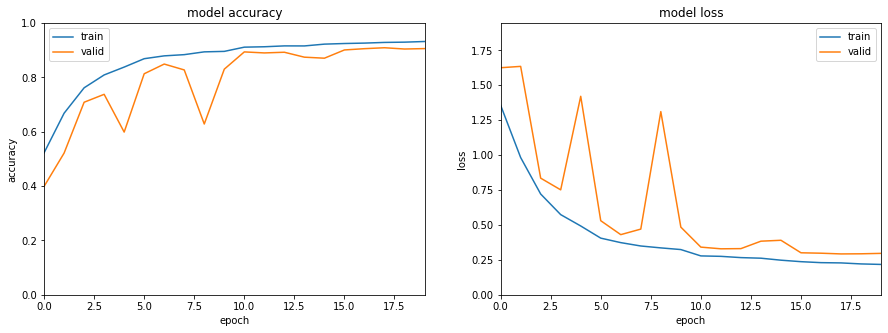

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# plot training history for accuracy
ax[0].plot(logs['accuracy'], label='train')
ax[0].plot(logs['val_accuracy'], label='valid')
ax[0].set_title('model accuracy')
ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, NUM_EPOCHS-1)
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(loc='best')

# plot training history for loss
ax[1].plot(logs['loss'], label='train')
ax[1].plot(logs['val_loss'], label='valid')
ax[1].set_title('model loss')
ax[1].set_ylim(0, -math.log(1/NUM_CLASSES))
ax[1].set_xlim(0, NUM_EPOCHS-1)
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='best')

fig.savefig(f'{MODEL_DIR}/training_history.png', dpi=100, format="png")
plt.show()

## 3.4 Modell-Evaluation

Bei der Modell-Evaluation soll nun überprüft werden, welche Klassifikationsgüte unserer trainiertes Modell auf ungesehenen Testdaten erzielt.

### Test Datensatz

Der Einfachheit halber werden im Folgenden die Validierungsdaten als Testdaten verwendet. __Wichtig!__ Dieses Vorgehen ist nicht optimal, da unsere Validierungsdaten aufgrund von Parameteranpassungen der Lernrate o.ä. nicht mehr unabhängig sind und es theoretisch zu einem Overfitting auf den Validierungsdaten kommen kann. 
Damit die Bewertung der Klassifikationsgüte des Modells aussagekräftig bleibt, sollte vor dem Modelltraining und der Parameteranpassung eine kleine Teilmenge des Datensatzes als unabhängige Testdaten zurückgehalten werden. 

Das Laden und Vorverarbeiten der Testdaten erfolgt auf die gleiche Weise wie in Abschnitt 2.

In [15]:
# test data pre-processing pipeline
test_transforms = transforms.Compose([
                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

# ImageFolder will read images found in subfolers of '/valid' and creates mini batches using the DataLoader
test_dataset = ImageFolder(root=VALID_DATA_DIR, transform=test_transforms)
test_loader = DataLoader(dataset=valid_dataset, 
                          shuffle=True, # shuffle only for visualization purposes else set to False 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multiprocessing
                          pin_memory=True)
print(f'Found {len(test_dataset.samples)} test images belonging to {len(test_dataset.classes)} classes: {test_dataset.classes}')

Found 3197 test images belonging to 7 classes: ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']


### Inferenz

Inferenz ist der Prozess, bei dem ein trainiertes Modell verwendet wird, um Vorhersagen für zuvor ungesehene Daten zu treffen. Während der Inferenz werden dem Modell Bilder der Testdaten als Eingabe präsentiert. Die Neuronen in der Ausgabeschicht des Modells erzeugen jeweils Ausgangsaktivierungen für jede Klasse des Datensatzes für jedes Einagbebild. Um die Aktivierungen der Ausgangsneuronen des Modells zu interpretieren, werden sie mit Hilfe der Softmax-Aktivierung in Vorhersagewahrscheinlichkeiten umgewandelt, so dass sich die Vorhersagewahrscheinlichkeiten aller Klassen zu 1 summieren. Die größte Vorhersagewahrscheinlichkeit einer Klasse wird dann als endgültige Modellvorhersage für das Eingabebild verwendet. 

Um anschließend die Klassifikationsgüte des Modells zu bestimmen, werden die Grundwahrheiten der Eingabebilder und die entsprechenden Modellvorhersagen zusammengefasst und Metriken (Macro Accuracy, Macro F1-Score, Recall, Precision) berechnet. 

In [16]:
# test metrics for evaluating the classification performance of the model 
test_accuracy_metric = Accuracy(num_classes=NUM_CLASSES, average="macro").to(device)
test_f1_metric = F1Score(num_classes=NUM_CLASSES, average="macro").to(device)
test_recall_metric = Recall(num_classes=NUM_CLASSES, average=None).to(device)
test_precision_metric = Precision(num_classes=NUM_CLASSES, average=None).to(device)
confusion_matrix_metric = ConfusionMatrix(num_classes=NUM_CLASSES, normalize=None, threshold=0.5).to(device)

# iterate over testdata batches (tqdm only for progress bar)
for (images, labels) in tqdm.tqdm(test_loader):
    # transfer images to the GPU for model inference
    images, labels = images.to(device), labels.to(device) 

    # model inference for each image in the batch 
    outputs = model(images) 
    prediction_probabilities = outputs.softmax(dim=-1) # compute the model prediction probabilities from logit outputs for all classes
    predictions = torch.argmax(prediction_probabilities, dim=-1) # get the class with the highest prediction probability for each image
    
    # update running test metrics
    test_accuracy_metric.update(predictions, labels)
    test_f1_metric.update(predictions, labels)
    test_recall_metric.update(predictions, labels)
    test_precision_metric.update(predictions, labels)
    confusion_matrix_metric.update(predictions, labels)
    
# calculate test metric results
test_accuracy = test_accuracy_metric.compute().detach().cpu().item()
test_f1 = test_f1_metric.compute().detach().cpu().item()
test_recall = test_recall_metric.compute().detach().cpu().numpy()
test_precision = test_precision_metric.compute().detach().cpu().numpy()
test_confusion_matrix = confusion_matrix_metric.compute().detach().cpu().numpy()

print(f"Testdata evaluation results:\nmacro Accuracy: {test_accuracy:.5f}\nmacro F1-Score: {test_f1:.5f}\n{pd.DataFrame({'Recall': test_recall, 'Precision': test_precision}, index = CLASSES)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.65it/s]

Testdata evaluation results:
macro Accuracy: 0.89199
macro F1-Score: 0.89067
               Recall  Precision
XR_ELBOW     0.879570   0.900881
XR_FINGER    0.947939   0.902893
XR_FOREARM   0.797342   0.727273
XR_HAND      0.932609   0.932609
XR_HUMERUS   0.805556   0.840580
XR_SHOULDER  0.943162   0.968978
XR_WRIST     0.937784   0.958140


### Konfusionsmatrix

Eine [Konfusionsmatrix](https://en.wikipedia.org/wiki/Confusion_matrix) ist hilfreich für die Interpretation der Klassifizierungsgüte des Modells. Mit ihr lässt sich feststellen, welche Klassen des Datensatzes vom Modell häufig richtig oder falsch klassifiziert werden sowie welche Klassen am häufigsten verwechselt werden. 

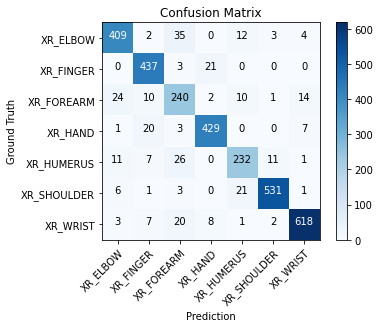

In [17]:
# confusion matrix computed earlier
cm = test_confusion_matrix
#print(f"confusion matrix:\n{cm}")

# plot confusion matrix
fig, ax = plt.subplots(1,1)
cm_fig = ax.imshow(cm, interpolation='nearest', cmap="Blues") # plot confusion matrix background color 
fig.colorbar(cm_fig, ax=ax) # add confusion matrix color bar
ax.set_xticks(np.arange(len(CLASSES)))
ax.set_yticks(np.arange(len(CLASSES)))
ax.set_xticklabels(CLASSES, rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(CLASSES)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth') 
ax.set_title("Confusion Matrix")

# plot confusion matrix values
for ix, iy in np.ndindex(cm.shape):
    ax.text(iy, ix, cm[ix, iy], horizontalalignment="center", color="white" if cm[ix, iy] > cm.max() / 2.0 else "black")    

fig.savefig(f'{MODEL_DIR}/confusion_matrix.png', dpi=100, format="png")
plt.show()    

### Inferenz mit Visualisierung

Es folgt die Inferenz für einen Minibatch der Testdaten, mit anschließender Visualisierung der Grundwahrheiten und Modellvorhersagen für jedes Bild des Minibatchs.

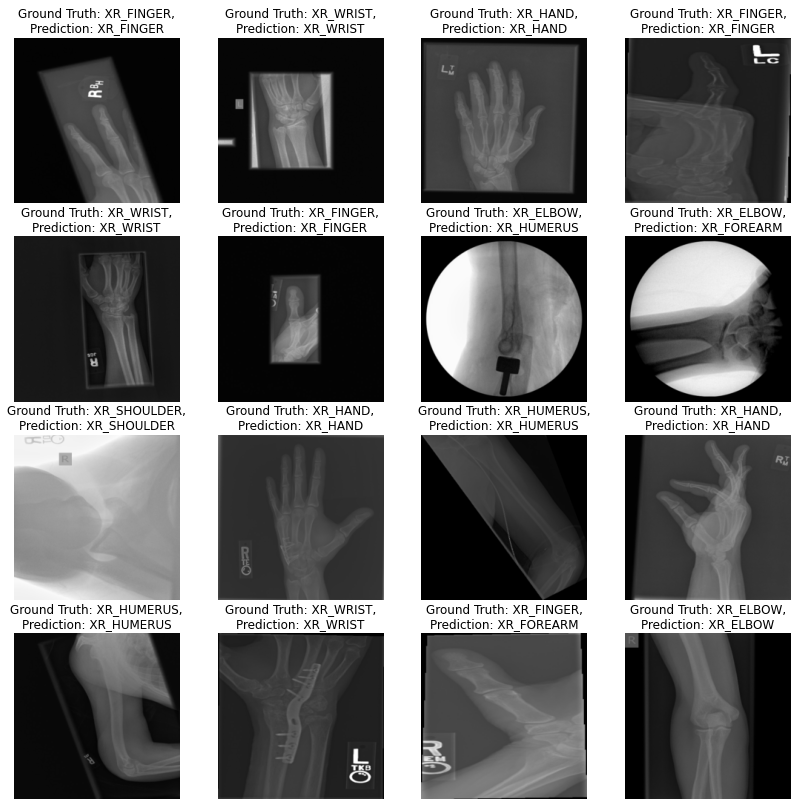

In [18]:
def denormalization(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean 
    return img

def show_predictions(images, labels, predictions):
    images = images.cpu().numpy() 
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()
    
    fig, ax = plt.subplots(4, 4, figsize=(14,14))
    for i, ax in enumerate(ax.flat):
        ax.imshow(denormalization(np.rollaxis(images[i,:,:,:],0,3)), vmin=0, vmax=1, cmap='gray') # np.rollaxis(images[i,:,:,:],0,3)) to swap channel axes to channels last
        ax.set_title(f"Ground Truth: {CLASSES[labels[i]]},\nPrediction: {CLASSES[predictions[i]]}")
        ax.axis('off')
    plt.show()

dataiter = iter(test_loader) # get iterator of test_loader 
images, labels = dataiter.next() # get a random batch of test_loader iterator

# transfer images to the GPU for model inference
images, labels = images.to(device), labels.to(device) 

# model inference for each image in the batch 
outputs = model(images) 
prediction_probabilities = outputs.softmax(dim=-1) # compute the model prediction probabilities from logit outputs for all classes
predictions = torch.argmax(prediction_probabilities, dim=-1) # get the class with the highest prediction probability for each image

show_predictions(images, labels, predictions) # show model predictions

### Grad-CAM

GradCAM (Gradient-weighted Class Activation Mapping) ist eine Methode zur visuellen Erläuterung der Modellvorhersage, die die Gradienteninformationen einer beliebigen Modellschicht nutzt und eine grobe Lokalisierungskarte der für die Modellvorhersage wichtigen Bildbereiche erstellt.

Weitere Details zur GradCAM: https://arxiv.org/abs/1610.02391  

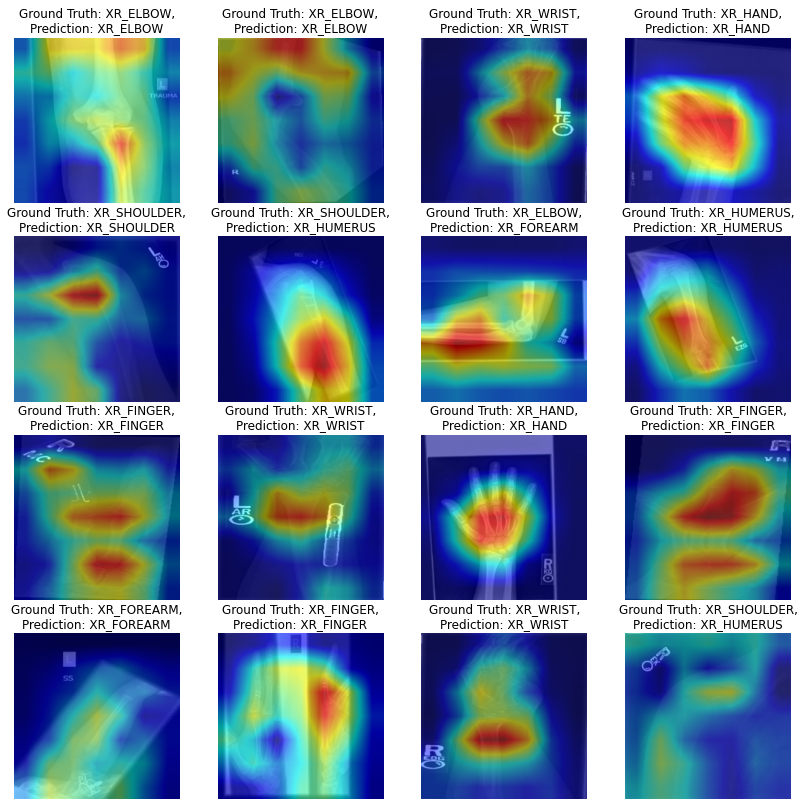

In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def denormalization(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean 
    return img

def visualize_gradcam(images, gradcam_activations, labels, predictions):
    fig, ax = plt.subplots(4, 4, figsize=(14,14))
    for i, ax in enumerate(ax.flat):
        img = denormalization(np.rollaxis(images[i,:,:,:],0,3)) # denormalize image and swap channel axes to channels last
        image_gradcam_overlay = show_cam_on_image(img, gradcam_activations[i,:,:], use_rgb=True) # overlay image with GradCAM activation map
        
        ax.imshow(image_gradcam_overlay, cmap='gray') 
        ax.set_title(f"Ground Truth: {CLASSES[labels[i]]},\nPrediction: {CLASSES[predictions[i]]}")
        ax.axis('off')
    plt.show()
    
    
# get a random batch of test_loader iterator
dataiter = iter(test_loader)  
images, labels = dataiter.next()
images = images.to(device) # transfer images to the GPU for model inference

# model inference, get predictions for each image in batch
outputs = model(images) 
prediction_probabilities = outputs.softmax(dim=-1) # compute the model prediction probability from logit outputs for all classes
predictions = torch.argmax(prediction_probabilities, dim=-1) # get the class with the highest prediction probability for each image

# get GradCAM for for each image in batch
gradcam_target_layers = [model.layer4[-1]] # choose the target layer to compute GradCAM
cam = GradCAM(model=model, target_layers=gradcam_target_layers, use_cuda=True) # multiple cams possible, see https://github.com/jacobgil/pytorch-grad-cam
gradcam_activations = cam(input_tensor=images, aug_smooth=True) # gradcam activation image (grayscale) 

visualize_gradcam(images.cpu().numpy(), gradcam_activations, labels, predictions.cpu().numpy())

### Out-Of-Class Bilder

Um zu testen wie unser Modell mit Bildern und Bildklassen umgeht die es noch nie gesehen hat, geben wir es nun das folgende Schädel CT-Bild:

<img src="https://prod-images-static.radiopaedia.org/images/17058746/a60ee77e6b44da2d72a25cea08dfd2_big_gallery.jpeg" width="300"/>
Quelle: radiopaedia.org

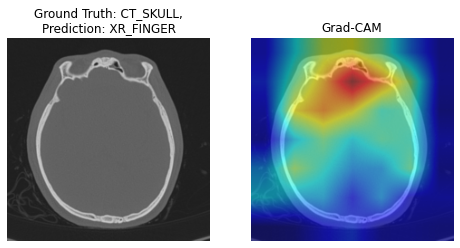

In [20]:
from PIL import Image
import requests

def denormalization(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean 
    return img


image_url = "https://prod-images-static.radiopaedia.org/images/17058746/a60ee77e6b44da2d72a25cea08dfd2_big_gallery.jpeg"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB") # load image from URL
label = "CT_SKULL" # define image label 

image = test_transforms(image).unsqueeze(dim=0) # normalize pixel values [-1,1] using the previous defined test pre-processing pipeline and expand image dims to [1,C,H,W]
image = image.to(device) # move image to GPU-VRAM

# model inference for image
output = model(image) 
prediction_probability = output.softmax(dim=-1) # compute the model prediction probability from logit output for all classes
prediction = torch.argmax(prediction_probability, dim=-1) # get the class with the highest prediction probability for the image

# gradcam activation image (grayscale) (see previous cell)
gradcam_activation = cam(input_tensor=image, aug_smooth=True) 

# visualize model prediction
image = image.cpu().numpy()
image = denormalization(np.rollaxis(image[0,:,:,:],0,3)) # np.rollaxis(image[0,:,:,:],0,3)) to swap channel axes to channels last
prediction = prediction.cpu().item()

fig, ax = plt.subplots(1, 2, figsize=(8,8))
ax[0].imshow(image, vmin=0, vmax=1, cmap='gray') 
image_gradcam_overlay = show_cam_on_image(image, gradcam_activation[0,:,:], use_rgb=True) # overlay image with GradCAM activation map
ax[1].imshow(image_gradcam_overlay, cmap='gray') 
ax[0].set_title(f"Ground Truth: {label},\nPrediction: {CLASSES[prediction]}")
ax[1].set_title(f"Grad-CAM")
ax[0].axis('off')
ax[1].axis('off')
plt.show()